In [1]:
!pip install --upgrade luxai_s2
!pip install pettingzoo==1.12.0 gym==0.21.0 stable-baselines3
!pip install --upgrade "importlib_metadata<5.0"

ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python >=3.6, <3.10; 1.11.0 Requires-Python >=3.6, <3.10; 1.11.1 Requires-Python >=3.6, <3.10; 1.11.2 Requires-Python >=3.6, <3.10; 1.12.0 Requires-Python >=3.6, <3.10; 1.13.0 Requires-Python >=3.7, <3.10; 1.13.1 Requires-Python >=3.7, <3.10; 1.4.0 Requires-Python >=3.6, <3.9; 1.4.1 Requires-Python >=3.6, <3.9; 1.4.2 Requires-Python >=3.6, <3.9; 1.5.0 Requires-Python >=3.6, <3.10; 1.5.1 Requires-Python >=3.6, <3.10; 1.5.2 Requires-Python >=3.6, <3.10; 1.6.0 Requires-Python >=3.6, <3.10; 1.6.1 Requires-Python >=3.6, <3.10; 1.7.0 Requires-Python >=3.6, <3.10; 1.8.0 Requires-Python >=3.6, <3.10; 1.8.1 Requires-Python >=3.6, <3.10; 1.8.2 Requires-Python >=3.6, <3.10; 1.9.0 Requires-Python >=3.6, <3.10
ERROR: Could not find a version that satisfies the requirement pettingzoo==1.12.0 (from versions: 0.1.0, 0.1.1, 0.1.2, 0.1.3, 0.1.4, 0.1.5, 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.1.10, 0.1.11, 0.1.12, 0.1.13

In [2]:
import importlib
import importlib_metadata
# kaggle has 6.0.0 installed but we need version <5.0
importlib.reload(importlib_metadata)

<module 'importlib_metadata' from '/opt/anaconda3/envs/Lux2/lib/python3.10/site-packages/importlib_metadata/__init__.py'>

In [3]:
import sys
from typing import Any, Dict

import numpy as np
import numpy.typing as npt
from gym import spaces


# Controller class copied here since you won't have access to the luxai_s2 package directly on the competition server
class Controller:
    def __init__(self, action_space: spaces.Space) -> None:
        self.action_space = action_space

    def action_to_lux_action(
        self, agent: str, obs: Dict[str, Any], action: npt.NDArray
    ):
        """
        Takes as input the current "raw observation" and the parameterized action and returns
        an action formatted for the Lux env
        """
        raise NotImplementedError()

    def action_masks(self, agent: str, obs: Dict[str, Any]):
        """
        Generates a boolean action mask indicating in each discrete dimension whether it would be valid or not
        """
        raise NotImplementedError()


class SimpleUnitDiscreteController(Controller):
    def __init__(self, env_cfg) -> None:
        """
        A simple controller that controls only the robot that will get spawned.
        Moreover, it will always try to spawn one heavy robot if there are none regardless of action given

        For the robot unit
        - 4 cardinal direction movement (4 dims)
        - a move center no-op action (1 dim)
        - transfer action just for transferring ice in 4 cardinal directions or center (5)
        - pickup action for power (1 dims)
        - dig action (1 dim)
        - no op action (1 dim) - equivalent to not submitting an action queue which costs power

        It does not include
        - self destruct action
        - recharge action
        - planning (via actions executing multiple times or repeating actions)
        - factory actions
        - transferring power or resources other than ice

        To help understand how to this controller works to map one action space to the original lux action space,
        see how the lux action space is defined in luxai_s2/spaces/action.py

        """
        self.env_cfg = env_cfg
        self.move_act_dims = 4
        self.transfer_act_dims = 5
        self.pickup_act_dims = 1
        self.dig_act_dims = 1
        self.no_op_dims = 1

        self.move_dim_high = self.move_act_dims
        self.transfer_dim_high = self.move_dim_high + self.transfer_act_dims
        self.pickup_dim_high = self.transfer_dim_high + self.pickup_act_dims
        self.dig_dim_high = self.pickup_dim_high + self.dig_act_dims
        self.no_op_dim_high = self.dig_dim_high + self.no_op_dims

        self.total_act_dims = self.no_op_dim_high
        action_space = spaces.Discrete(self.total_act_dims)
        super().__init__(action_space)

    def _is_move_action(self, id):
        return id < self.move_dim_high

    def _get_move_action(self, id):
        # move direction is id + 1 since we don't allow move center here
        return np.array([0, id + 1, 0, 0, 0, 1])

    def _is_transfer_action(self, id):
        return id < self.transfer_dim_high

    def _get_transfer_action(self, id):
        id = id - self.move_dim_high
        transfer_dir = id % 5
        return np.array([1, transfer_dir, 0, self.env_cfg.max_transfer_amount, 0, 1])

    def _is_pickup_action(self, id):
        return id < self.pickup_dim_high

    def _get_pickup_action(self, id):
        return np.array([2, 0, 4, self.env_cfg.max_transfer_amount, 0, 1])

    def _is_dig_action(self, id):
        return id < self.dig_dim_high

    def _get_dig_action(self, id):
        return np.array([3, 0, 0, 0, 0, 1])

    def action_to_lux_action(
        self, agent: str, obs: Dict[str, Any], action: npt.NDArray
    ):
        shared_obs = obs["player_0"]
        lux_action = dict()
        units = shared_obs["units"][agent]
        for unit_id in units.keys():
            unit = units[unit_id]
            choice = action
            action_queue = []
            no_op = False
            if self._is_move_action(choice):
                action_queue = [self._get_move_action(choice)]
            elif self._is_transfer_action(choice):
                action_queue = [self._get_transfer_action(choice)]
            elif self._is_pickup_action(choice):
                action_queue = [self._get_pickup_action(choice)]
            elif self._is_dig_action(choice):
                action_queue = [self._get_dig_action(choice)]
            else:
                # action is a no_op, so we don't update the action queue
                no_op = True

            # simple trick to help agents conserve power is to avoid updating the action queue
            # if the agent was previously trying to do that particular action already
            if len(unit["action_queue"]) > 0 and len(action_queue) > 0:
                same_actions = (unit["action_queue"][0] == action_queue[0]).all()
                if same_actions:
                    no_op = True
            if not no_op:
                lux_action[unit_id] = action_queue

            break

        factories = shared_obs["factories"][agent]
        if len(units) == 0:
            for unit_id in factories.keys():
                lux_action[unit_id] = 1  # build a single heavy

        return lux_action

    def action_masks(self, agent: str, obs: Dict[str, Any]):
        """
        Defines a simplified action mask for this controller's action space

        Doesn't account for whether robot has enough power
        """

        # compute a factory occupancy map that will be useful for checking if a board tile
        # has a factory and which team's factory it is.
        shared_obs = obs[agent]
        factory_occupancy_map = (
            np.ones_like(shared_obs["board"]["rubble"], dtype=int) * -1
        )
        factories = dict()
        for player in shared_obs["factories"]:
            factories[player] = dict()
            for unit_id in shared_obs["factories"][player]:
                f_data = shared_obs["factories"][player][unit_id]
                f_pos = f_data["pos"]
                # store in a 3x3 space around the factory position it's strain id.
                factory_occupancy_map[
                    f_pos[0] - 1 : f_pos[0] + 2, f_pos[1] - 1 : f_pos[1] + 2
                ] = f_data["strain_id"]

        units = shared_obs["units"][agent]
        action_mask = np.zeros((self.total_act_dims), dtype=bool)
        for unit_id in units.keys():
            action_mask = np.zeros(self.total_act_dims)
            # movement is always valid
            action_mask[:4] = True

            # transferring is valid only if the target exists
            unit = units[unit_id]
            pos = np.array(unit["pos"])
            # a[1] = direction (0 = center, 1 = up, 2 = right, 3 = down, 4 = left)
            move_deltas = np.array([[0, 0], [0, -1], [1, 0], [0, 1], [-1, 0]])
            for i, move_delta in enumerate(move_deltas):
                transfer_pos = np.array(
                    [pos[0] + move_delta[0], pos[1] + move_delta[1]]
                )
                # check if theres a factory tile there
                if (
                    transfer_pos[0] < 0
                    or transfer_pos[1] < 0
                    or transfer_pos[0] >= len(factory_occupancy_map)
                    or transfer_pos[1] >= len(factory_occupancy_map[0])
                ):
                    continue
                factory_there = factory_occupancy_map[transfer_pos[0], transfer_pos[1]]
                if factory_there in shared_obs["teams"][agent]["factory_strains"]:
                    action_mask[
                        self.transfer_dim_high - self.transfer_act_dims + i
                    ] = True

            factory_there = factory_occupancy_map[pos[0], pos[1]]
            on_top_of_factory = (
                factory_there in shared_obs["teams"][agent]["factory_strains"]
            )

            # dig is valid only if on top of tile with rubble or resources or lichen
            board_sum = (
                shared_obs["board"]["ice"][pos[0], pos[1]]
                + shared_obs["board"]["ore"][pos[0], pos[1]]
                + shared_obs["board"]["rubble"][pos[0], pos[1]]
                + shared_obs["board"]["lichen"][pos[0], pos[1]]
            )
            if board_sum > 0 and not on_top_of_factory:
                action_mask[
                    self.dig_dim_high - self.dig_act_dims : self.dig_dim_high
                ] = True

            # pickup is valid only if on top of factory tile
            if on_top_of_factory:
                action_mask[
                    self.pickup_dim_high - self.pickup_act_dims : self.pickup_dim_high
                ] = True
                action_mask[
                    self.dig_dim_high - self.dig_act_dims : self.dig_dim_high
                ] = False

            # no-op is always valid
            action_mask[-1] = True
            break
        return action_mask

In [4]:
from typing import Any, Dict

import gym
import numpy as np
import numpy.typing as npt
from gym import spaces


class SimpleUnitObservationWrapper(gym.ObservationWrapper):
    """
    A simple state based observation to work with in pair with the SimpleUnitDiscreteController

    It contains info only on the first robot, the first factory you own, and some useful features. If there are no owned robots the observation is just zero.
    No information about the opponent is included. This will generate observations for all teams.

    Included features:
    - First robot's stats
    - distance vector to closest ice tile
    - distance vector to first factory

    """

    def __init__(self, env: gym.Env) -> None:
        super().__init__(env)
        self.observation_space = spaces.Box(-999, 999, shape=(13,))

    def observation(self, obs):
        return SimpleUnitObservationWrapper.convert_obs(obs, self.env.state.env_cfg)

    # we make this method static so the submission/evaluation code can use this as well
    @staticmethod
    def convert_obs(obs: Dict[str, Any], env_cfg: Any) -> Dict[str, npt.NDArray]:
        observation = dict()
        shared_obs = obs["player_0"]
        ice_map = shared_obs["board"]["ice"]
        ice_tile_locations = np.argwhere(ice_map == 1)

        for agent in obs.keys():
            obs_vec = np.zeros(
                13,
            )

            factories = shared_obs["factories"][agent]
            factory_vec = np.zeros(2)
            for k in factories.keys():
                # here we track a normalized position of the first friendly factory
                factory = factories[k]
                factory_vec = np.array(factory["pos"]) / env_cfg.map_size
                break
            units = shared_obs["units"][agent]
            for k in units.keys():
                unit = units[k]

                # store cargo+power values scaled to [0, 1]
                cargo_space = env_cfg.ROBOTS[unit["unit_type"]].CARGO_SPACE
                battery_cap = env_cfg.ROBOTS[unit["unit_type"]].BATTERY_CAPACITY
                cargo_vec = np.array(
                    [
                        unit["power"] / battery_cap,
                        unit["cargo"]["ice"] / cargo_space,
                        unit["cargo"]["ore"] / cargo_space,
                        unit["cargo"]["water"] / cargo_space,
                        unit["cargo"]["metal"] / cargo_space,
                    ]
                )
                unit_type = (
                    0 if unit["unit_type"] == "LIGHT" else 1
                )  # note that build actions use 0 to encode Light
                # normalize the unit position
                pos = np.array(unit["pos"]) / env_cfg.map_size
                unit_vec = np.concatenate(
                    [pos, [unit_type], cargo_vec, [unit["team_id"]]], axis=-1
                )

                # we add some engineered features down here
                # compute closest ice tile
                ice_tile_distances = np.mean(
                    (ice_tile_locations - np.array(unit["pos"])) ** 2, 1
                )
                # normalize the ice tile location
                closest_ice_tile = (
                    ice_tile_locations[np.argmin(ice_tile_distances)] / env_cfg.map_size
                )
                obs_vec = np.concatenate(
                    [unit_vec, factory_vec - pos, closest_ice_tile - pos], axis=-1
                )
                break
            observation[agent] = obs_vec

        return observation

In [5]:
from typing import Callable, Dict

import gym
import numpy as np
import numpy.typing as npt
from gym import spaces

import luxai_s2.env
from luxai_s2.env import LuxAI_S2
from luxai_s2.state import ObservationStateDict
from luxai_s2.unit import ActionType, BidActionType, FactoryPlacementActionType
from luxai_s2.utils import my_turn_to_place_factory
from luxai_s2.wrappers.controllers import (
    Controller,
)


class SB3Wrapper(gym.Wrapper):
    def __init__(
        self,
        env: LuxAI_S2,
        bid_policy: Callable[
            [str, ObservationStateDict], Dict[str, BidActionType]
        ] = None,
        factory_placement_policy: Callable[
            [str, ObservationStateDict], Dict[str, FactoryPlacementActionType]
        ] = None,
        controller: Controller = None,
    ) -> None:
        """
        A environment wrapper for Stable Baselines 3. It reduces the LuxAI_S2 env
        into a single phase game and places the first two phases (bidding and factory placement) into the env.reset function so that
        interacting agents directly start generating actions to play the third phase of the game.

        It also accepts a Controller that translates action's in one action space to a Lux S2 compatible action

        Parameters
        ----------
        bid_policy: Function
            A function accepting player: str and obs: ObservationStateDict as input that returns a bid action
            such as dict(bid=10, faction="AlphaStrike"). By default will bid 0
        factory_placement_policy: Function
            A function accepting player: str and obs: ObservationStateDict as input that returns a factory placement action
            such as dict(spawn=np.array([2, 4]), metal=150, water=150). By default will spawn in a random valid location with metal=150, water=150
        controller : Controller
            A controller that parameterizes the action space into something more usable and converts parameterized actions to lux actions.
            See luxai_s2/wrappers/controllers.py for available controllers and how to make your own
        """
        gym.Wrapper.__init__(self, env)
        self.env = env
        
        assert controller is not None
        
        # set our controller and replace the action space
        self.controller = controller
        self.action_space = controller.action_space

        # The simplified wrapper removes the first two phases of the game by using predefined policies (trained or heuristic)
        # to handle those two phases during each reset
        if factory_placement_policy is None:
            def factory_placement_policy(player, obs: ObservationStateDict):
                potential_spawns = np.array(
                    list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
                )
                spawn_loc = potential_spawns[
                    np.random.randint(0, len(potential_spawns))
                ]
                return dict(spawn=spawn_loc, metal=150, water=150)

        self.factory_placement_policy = factory_placement_policy
        if bid_policy is None:
            def bid_policy(player, obs: ObservationStateDict):
                faction = "AlphaStrike"
                if player == "player_1":
                    faction = "MotherMars"
                return dict(bid=0, faction=faction)

        self.bid_policy = bid_policy

        self.prev_obs = None

    def step(self, action: Dict[str, npt.NDArray]):
        
        # here, for each agent in the game we translate their action into a Lux S2 action
        lux_action = dict()
        for agent in self.env.agents:
            if agent in action:
                lux_action[agent] = self.controller.action_to_lux_action(
                    agent=agent, obs=self.prev_obs, action=action[agent]
                )
            else:
                lux_action[agent] = dict()
        
        # lux_action is now a dict mapping agent name to an action
        obs, reward, done, info = self.env.step(lux_action)
        self.prev_obs = obs
        return obs, reward, done, info

    def reset(self, **kwargs):
        # we upgrade the reset function here
        
        # we call the original reset function first
        obs = self.env.reset(**kwargs)
        
        # then use the bid policy to go through the bidding phase
        action = dict()
        for agent in self.env.agents:
            action[agent] = self.bid_policy(agent, obs[agent])
        obs, _, _, _ = self.env.step(action)
        
        # while real_env_steps < 0, we are in the factory placement phase
        # so we use the factory placement policy to step through this
        while self.env.state.real_env_steps < 0:
            action = dict()
            for agent in self.env.agents:
                if my_turn_to_place_factory(
                    obs["player_0"]["teams"][agent]["place_first"],
                    self.env.state.env_steps,
                ):
                    action[agent] = self.factory_placement_policy(agent, obs[agent])
                else:
                    action[agent] = dict()
            obs, _, _, _ = self.env.step(action)
        self.prev_obs = obs
        
        return obs

In [6]:
def zero_bid(player, obs):
    # a policy that always bids 0
    faction = "AlphaStrike"
    if player == "player_1":
        faction = "MotherMars"
    return dict(bid=0, faction=faction)

def place_near_random_ice(player, obs):
    """
    This policy will place a single factory with all the starting resources
    near a random ice tile
    """
    if obs["teams"][player]["metal"] == 0:
        return dict()
    potential_spawns = list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
    potential_spawns_set = set(potential_spawns)
    done_search = False
    
    # simple numpy trick to find locations adjacent to ice tiles.
    ice_diff = np.diff(obs["board"]["ice"])
    pot_ice_spots = np.argwhere(ice_diff == 1)
    if len(pot_ice_spots) == 0:
        pot_ice_spots = potential_spawns
    
    # pick a random ice spot and search around it for spawnable locations.
    trials = 5
    while trials > 0:
        pos_idx = np.random.randint(0, len(pot_ice_spots))
        pos = pot_ice_spots[pos_idx]
        area = 3
        for x in range(area):
            for y in range(area):
                check_pos = [pos[0] + x - area // 2, pos[1] + y - area // 2]
                if tuple(check_pos) in potential_spawns_set:
                    done_search = True
                    pos = check_pos
                    break
            if done_search:
                break
        if done_search:
            break
        trials -= 1
    
    if not done_search:
        spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
        pos = spawn_loc
    
    # this will spawn a factory at pos and with all the starting metal and water
    metal = obs["teams"][player]["metal"]
    return dict(spawn=pos, metal=metal, water=metal)

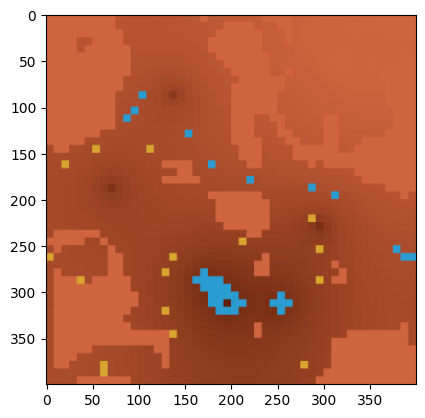

In [7]:
import matplotlib.pyplot as plt
env = gym.make("LuxAI_S2-v0")
env.reset(seed=0)
img = env.render("rgb_array")
plt.imshow(img)

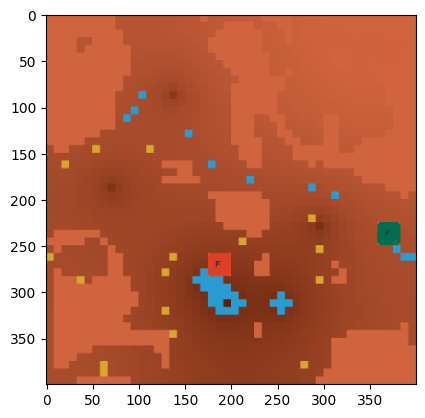

In [8]:
import matplotlib.pyplot as plt
env = gym.make("LuxAI_S2-v0")
env = SB3Wrapper(env, zero_bid, place_near_random_ice, controller=SimpleUnitDiscreteController(env.env_cfg))
env.reset(seed=0)
img = env.render("rgb_array")
plt.imshow(img)

In [9]:
import copy
class CustomEnvWrapper(gym.Wrapper):
    def __init__(self, env: gym.Env) -> None:
        """
        Adds a custom reward and turns the LuxAI_S2 environment into a single-agent environment for easy training
        """
        super().__init__(env)
        self.prev_step_metrics = None

    def step(self, action):
        agent = "player_0"
        opp_agent = "player_1"

        opp_factories = self.env.state.factories[opp_agent]
        for k in opp_factories.keys():
            factory = opp_factories[k]
             # set enemy factories to have 1000 water to keep them alive the whole around and treat the game as single-agent
            factory.cargo.water = 1000

        # submit actions for just one agent to make it single-agent
        # and save single-agent versions of the data below
        action = {agent: action}
        obs, _, done, info = self.env.step(action)
        obs = obs[agent]
        done = done[agent]
        
        # we collect stats on teams here. These are useful stats that can be used to help generate reward functions
        stats: StatsStateDict = self.env.state.stats[agent]

        info = dict()
        metrics = dict()
        metrics["ice_dug"] = (
            stats["generation"]["ice"]["HEAVY"] + stats["generation"]["ice"]["LIGHT"]
        )
        metrics["water_produced"] = stats["generation"]["water"]

        # we save these two to see often the agent updates robot action queues and how often enough
        # power to do so and succeed (less frequent updates = more power is saved)
        metrics["action_queue_updates_success"] = stats["action_queue_updates_success"]
        metrics["action_queue_updates_total"] = stats["action_queue_updates_total"]

        # we can save the metrics to info so we can use tensorboard to log them to get a glimpse into how our agent is behaving
        info["metrics"] = metrics

        reward = 0
        if self.prev_step_metrics is not None:
            # we check how much ice and water is produced and reward the agent for generating both
            ice_dug_this_step = metrics["ice_dug"] - self.prev_step_metrics["ice_dug"]
            water_produced_this_step = (
                metrics["water_produced"] - self.prev_step_metrics["water_produced"]
            )
            # we reward water production more as it is the most important resource for survival
            reward = ice_dug_this_step / 100 + water_produced_this_step

        self.prev_step_metrics = copy.deepcopy(metrics)
        return obs, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)["player_0"]
        self.prev_step_metrics = None
        return obs

In [10]:
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from gym.wrappers import TimeLimit
def make_env(env_id: str, rank: int, seed: int = 0, max_episode_steps=200):
    def _init() -> gym.Env:
        # verbose = 0
        # collect_stats=True lets us track stats like total ice dug during an episode to help create reward functions
        # max factories set to 2 for simplification and keeping returns consistent as we survive longer 
        # if there are more initial resources
        env = gym.make(env_id, verbose=0, collect_stats=True, MAX_FACTORIES=2)

        # Add a SB3 wrapper to make it work with SB3 and simplify the action space with the controller
        # this will remove the bidding phase and factory placement phase. For factory placement we use
        # the provided place_near_random_ice function which will randomly select an ice tile and place a factory near it.
        env = SB3Wrapper(
            env,
            factory_placement_policy=place_near_random_ice,
            controller=SimpleUnitDiscreteController(env.env_cfg),
        )
        
        # changes observation to include a few simple features
        env = SimpleUnitObservationWrapper(
            env
        )
        
        # convert to single agent, adds our reward
        env = CustomEnvWrapper(env)  
        
        # Add a timelimit to the environment, which can truncate episodes, speed up training
        env = TimeLimit(
            env, max_episode_steps=max_episode_steps
        )
        env = Monitor(env) # for SB3 to allow it to record metrics
        env.reset(seed=seed + rank)
        set_random_seed(seed)
        return env

    return _init

In [11]:
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
class TensorboardCallback(BaseCallback):
    def __init__(self, tag: str, verbose=0):
        super().__init__(verbose)
        self.tag = tag

    def _on_step(self) -> bool:
        c = 0

        for i, done in enumerate(self.locals["dones"]):
            if done:
                info = self.locals["infos"][i]
                c += 1
                for k in info["metrics"]:
                    stat = info["metrics"][k]
                    self.logger.record_mean(f"{self.tag}/{k}", stat)
        return True

In [12]:
import os.path as osp
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.ppo import PPO

set_random_seed(42)
log_path = "logs/exp_1"
num_envs = 4

# set max episode steps to 200 for training environments to train faster
env = SubprocVecEnv([make_env("LuxAI_S2-v0", i, max_episode_steps=200) for i in range(num_envs)])
env.reset()
# set max episode steps to 1000 to match original environment
eval_env = SubprocVecEnv([make_env("LuxAI_S2-v0", i, max_episode_steps=1000) for i in range(4)])
eval_env.reset()
rollout_steps = 100
policy_kwargs = dict(net_arch=(128, 128))
model = PPO(
    "MlpPolicy",
    env,
    n_steps=rollout_steps // num_envs,
    batch_size=800,
    learning_rate=3e-4,
    policy_kwargs=policy_kwargs,
    verbose=1,
    n_epochs=2,
    target_kl=0.05,
    gamma=0.99,
    tensorboard_log=osp.join(log_path),
)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=osp.join(log_path, "models"),
    log_path=osp.join(log_path, "eval_logs"),
    eval_freq=24_000,
    deterministic=False,
    render=False,
    n_eval_episodes=5,
)

Using cpu device


/opt/anaconda3/envs/Lux2/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:145: UserWarning: You have specified a mini-batch size of 800, but because the `RolloutBuffer` is of size `n_steps * n_envs = 100`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 100
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=25 and n_envs=4)
  warnings.warn(
